
# SUPPORT VECTOR MACHINE (SVM) MODEL - COMPREHENSIVE TRAINING & OPTIMIZATION
============================================================================

📚 ABOUT SUPPORT VECTOR MACHINES (SVM):
---------------------------------------
Support Vector Machines are powerful supervised learning algorithms that work by:

🎯 KEY CONCEPT: Finding the optimal hyperplane that separates different classes
- Creates decision boundaries with maximum margin between classes
- Uses support vectors (data points closest to the boundary) to define the hyperplane
- Can handle both linear and non-linear classification using kernel tricks

🔧 SVM KERNELS:
- Linear: Best for linearly separable data, fastest training
- RBF (Radial Basis Function): Most popular, handles non-linear patterns well
- Polynomial: Good for specific non-linear patterns
- Sigmoid: Similar to neural networks, less commonly used

⚙️ KEY HYPERPARAMETERS:
- C (Regularization): Controls trade-off between smooth boundary vs classifying training points correctly
  * High C: Complex model, may overfit (hard margin)
  * Low C: Simpler model, may underfit (soft margin)
- Gamma (for RBF/Poly kernels): Controls influence of single training examples
  * High gamma: Close influence, complex boundaries (may overfit)
  * Low gamma: Far influence, smoother boundaries

⚠️ IMPORTANT SVM REQUIREMENTS:
- Feature scaling is MANDATORY (SVM is sensitive to feature scales)
- Can be computationally expensive for large datasets
- Memory intensive (stores support vectors)

🎯 SVM ADVANTAGES:
- Excellent for high-dimensional data
- Memory efficient (uses subset of training points)
- Versatile (different kernels for different data types)
- Works well with clear margin separation

⚠️ SVM DISADVANTAGES:
- Slow on large datasets
- Sensitive to feature scaling
- No direct probability estimates
- Difficult to interpret

📊 EXPECTED PERFORMANCE:
This optimization will test multiple kernel types and hyperparameters.
Given our dataset size (~27K samples), expect longer training times than tree-based models.

⏱️ ESTIMATED RUNTIME: 3-6 hours (depending on parameter grid complexity)
"""

In [2]:
# ================================================================
# 1: Import Libraries & Setup
# ================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import cross_val_score, GridSearchCV
import warnings
warnings.filterwarnings('ignore')
import time
import os
import joblib
import json
from datetime import datetime

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette(["#1f4e79"])   # a strong, navy‑blue

print("📚 Libraries imported successfully!")
print("🔧 SVM requires feature scaling - StandardScaler will be applied")

📚 Libraries imported successfully!
🔧 SVM requires feature scaling - StandardScaler will be applied


In [3]:
# ================================================================
# 2. LOAD SAVED DATA
# ================================================================
print("📂 Loading saved training and test data...")
print("=" * 50)

try:
    # Load features
    X_train_raw = pd.read_csv('../Data/output/X_train_encoded.csv')
    X_test_raw = pd.read_csv('../Data/output/X_test_encoded.csv')
    
    # Load labels
    y_train_svm = pd.read_csv('../Data/output/y_train.csv').squeeze()  # squeeze() converts DataFrame to Series
    y_test_svm = pd.read_csv('../Data/output/y_test.csv').squeeze()
    
    print("✅ Data loaded successfully!")
    print(f"   Training features: {X_train_raw.shape}")
    print(f"   Test features: {X_test_raw.shape}")
    print(f"   Training labels: {y_train_svm.shape}")
    print(f"   Test labels: {y_test_svm.shape}")
    
except FileNotFoundError as e:
    print(f"❌ Error: Could not find data files. {e}")
    print("Make sure you've run the encoding notebook first!")
except Exception as e:
    print(f"❌ Error loading data: {e}")

📂 Loading saved training and test data...
✅ Data loaded successfully!
   Training features: (22180, 20)
   Test features: (5545, 20)
   Training labels: (22180,)
   Test labels: (5545,)


In [4]:
# ================================================================
# 3. ANALYZE CLASS DISTRIBUTION (DETERMINES BEST SCORING METRIC)
# ================================================================

print("📊 ANALYZING CLASS DISTRIBUTION")
print("=" * 50)

# Check target variable distribution using your training data
class_counts = pd.Series(y_train_svm).value_counts().sort_index()
class_percentages = pd.Series(y_train_svm).value_counts(normalize=True).sort_index() * 100

print("Class distribution in training data:")
for class_label, count in class_counts.items():
    percentage = class_percentages[class_label]
    print(f"  Class {class_label}: {count:,} samples ({percentage:.1f}%)")

# Calculate imbalance ratio
max_class_count = class_counts.max()
min_class_count = class_counts.min()
imbalance_ratio = max_class_count / min_class_count

print(f"\n📈 Imbalance Analysis:")
print(f"  Largest class: {max_class_count:,} samples")
print(f"  Smallest class: {min_class_count:,} samples")
print(f"  Imbalance ratio: {imbalance_ratio:.2f}:1")

# Determine best scoring metric
if imbalance_ratio > 2.0:
    print("⚠️  Dataset appears imbalanced - F1-weighted recommended")
    recommended_scoring = 'f1_weighted'
    scoring_explanation = "F1-weighted handles class imbalance better than accuracy"
else:
    print("✅ Dataset appears balanced - accuracy is acceptable")
    recommended_scoring = 'accuracy'
    scoring_explanation = "Accuracy is reliable for balanced datasets"

print(f"🎯 Recommended scoring: {recommended_scoring}")
print(f"💡 Why: {scoring_explanation}")

📊 ANALYZING CLASS DISTRIBUTION
Class distribution in training data:
  Class 0: 4,237 samples (19.1%)
  Class 1: 5,634 samples (25.4%)
  Class 2: 12,309 samples (55.5%)

📈 Imbalance Analysis:
  Largest class: 12,309 samples
  Smallest class: 4,237 samples
  Imbalance ratio: 2.91:1
⚠️  Dataset appears imbalanced - F1-weighted recommended
🎯 Recommended scoring: f1_weighted
💡 Why: F1-weighted handles class imbalance better than accuracy


In [5]:
# ================================================================
# 4. FEATURE SCALING (MANDATORY FOR SVM)
# ================================================================

print(f"\n⚙️ FEATURE SCALING FOR SVM")
print("=" * 50)
print("🔧 SVM requires feature scaling - applying StandardScaler...")

# Initialize the scaler
scaler = StandardScaler()

# Fit scaler on training data and transform both train and test
X_train_svm = pd.DataFrame(
    scaler.fit_transform(X_train_raw),
    columns=X_train_raw.columns,
    index=X_train_raw.index
)

X_test_svm = pd.DataFrame(
    scaler.transform(X_test_raw),
    columns=X_test_raw.columns,
    index=X_test_raw.index
)

print("✅ Feature scaling completed!")
print(f"   Scaled training features: {X_train_svm.shape}")
print(f"   Scaled test features: {X_test_svm.shape}")

# Show scaling effect
print(f"\n📊 Scaling Effect (first 3 features):")
print("Before scaling (mean ± std):")
for col in X_train_raw.columns[:3]:
    mean_val = X_train_raw[col].mean()
    std_val = X_train_raw[col].std()
    print(f"  {col}: {mean_val:.3f} ± {std_val:.3f}")

print("After scaling (mean ± std):")
for col in X_train_svm.columns[:3]:
    mean_val = X_train_svm[col].mean()
    std_val = X_train_svm[col].std()
    print(f"  {col}: {mean_val:.3f} ± {std_val:.3f}")

print("💡 All features now have mean≈0 and std≈1 (standardized)")


⚙️ FEATURE SCALING FOR SVM
🔧 SVM requires feature scaling - applying StandardScaler...
✅ Feature scaling completed!
   Scaled training features: (22180, 20)
   Scaled test features: (5545, 20)

📊 Scaling Effect (first 3 features):
Before scaling (mean ± std):
  excellent_Score: 0.602 ± 0.490
  active_in_VLE: 0.358 ± 0.479
  student_engagementt: 0.692 ± 0.462
After scaling (mean ± std):
  excellent_Score: 0.000 ± 1.000
  active_in_VLE: 0.000 ± 1.000
  student_engagementt: -0.000 ± 1.000
💡 All features now have mean≈0 and std≈1 (standardized)


In [12]:
# ================================================================
# 5. DEFINE PARAMETER GRIDS (CHOOSE YOUR SPEED VS THOROUGHNESS)
# ================================================================

print(f"\n🔧 SVM PARAMETER GRID OPTIONS")
print("=" * 50)

# Option 1: FAST Grid (2-3 hours)
fast_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
    'class_weight': ['balanced', None]
}
#fast_param_grid = {
#    'C': [1],
#    'kernel': ['linear'],
#    'gamma': ['scale'],
#    'class_weight': ['balanced']
#}

# Option 2: COMPREHENSIVE Grid (6-10 hours)
comprehensive_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'degree': [2, 3, 4],  # Only used with poly kernel
    'class_weight': ['balanced', None]
}

# Option 3: SMART Grid (3-5 hours) - RECOMMENDED
smart_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.01, 0.1],
    'class_weight': ['balanced', None]
}

# Choose which grid to use (CHANGE THIS IF YOU WANT DIFFERENT SPEED)
chosen_param_grid = fast_param_grid  # RECOMMENDED for first run
grid_name = "FAST"

# For polynomial kernel, we need to handle degree parameter
if any('poly' in str(v) for v in chosen_param_grid.get('kernel', [])):
    # Convert to list of parameter dictionaries for polynomial handling
    param_combinations = []
    for kernel in chosen_param_grid['kernel']:
        if kernel == 'poly':
            # Add polynomial-specific parameters
            poly_params = {k: v for k, v in chosen_param_grid.items() if k != 'kernel'}
            poly_params['kernel'] = ['poly']
            poly_params['degree'] = [2, 3, 4]
            param_combinations.append(poly_params)
        else:
            # Remove degree for non-polynomial kernels
            other_params = {k: v for k, v in chosen_param_grid.items() if k not in ['kernel', 'degree']}
            other_params['kernel'] = [kernel]
            param_combinations.append(other_params)
    chosen_param_grid = param_combinations

# Calculate combinations
if isinstance(chosen_param_grid, list):
    total_combinations = sum(np.prod([len(v) for v in param_dict.values()]) for param_dict in chosen_param_grid)
else:
    total_combinations = np.prod([len(v) for v in chosen_param_grid.values()])

print(f"🎯 Using {grid_name} parameter grid")
print(f"📊 Total combinations to test: {total_combinations}")

if grid_name == "FAST":
    print("⏱️  Estimated time: 2-3 hours")
    print("🔍 Testing: Linear & RBF kernels, basic C values")
elif grid_name == "SMART":
    print("⏱️  Estimated time: 3-5 hours")
    print("🔍 Testing: Extended C range, multiple gamma values")
else:
    print("⏱️  Estimated time: 6-10 hours")
    print("🔍 Testing: All kernels, extensive parameter space")

print(f"\n⚠️  SVM WARNING: Training time scales quadratically with dataset size")
print(f"   With {len(X_train_svm)} samples, expect significant computation time")



🔧 SVM PARAMETER GRID OPTIONS
🎯 Using FAST parameter grid
📊 Total combinations to test: 24
⏱️  Estimated time: 2-3 hours
🔍 Testing: Linear & RBF kernels, basic C values

⚠️  SVM WARNING: Training time scales quadratically with dataset size
   With 22180 samples, expect significant computation time


In [13]:
# ================================================================
# 6. SETUP MULTI-SCORING GRIDSEARCHCV
# ================================================================

print(f"\n🎯 SVM GRIDSEARCHCV CONFIGURATION")
print("=" * 50)

# Define multiple scoring metrics
scoring_metrics = {
    'accuracy': 'accuracy',
    'f1_weighted': 'f1_weighted',
    'f1_macro': 'f1_macro',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted'
}

cv_folds = 5  # Reduced from potential higher values due to SVM's computational cost
print(f"🎯 Primary scoring metric: {recommended_scoring}")
print(f"📊 Additional metrics tracked: {list(scoring_metrics.keys())}")
print(f"🔄 Cross-validation folds: {cv_folds}")
print(f"💻 Parallel processing: Enabled (n_jobs=-1)")
print(f"🧮 SVM-specific notes:")
print(f"   - Feature scaling: ✅ Applied (StandardScaler)")
print(f"   - Memory usage: High (stores support vectors)")
print(f"   - Training complexity: O(n²) to O(n³)")

# Configure GridSearchCV
grid_search = GridSearchCV(
    estimator=SVC(
        random_state=42,
        probability=True,  # Enable probability estimates
        cache_size=1000   # Increase cache for faster training
    ),
    param_grid=chosen_param_grid,
    scoring=scoring_metrics,
    refit=recommended_scoring,  # Refit using the best metric for your data
    cv=cv_folds,               # 5-fold CV for balance of accuracy vs speed
    n_jobs=-1,                 # Use all CPU cores
    verbose=2,                 # Show detailed progress
    return_train_score=True    # Track overfitting
)



🎯 SVM GRIDSEARCHCV CONFIGURATION
🎯 Primary scoring metric: f1_weighted
📊 Additional metrics tracked: ['accuracy', 'f1_weighted', 'f1_macro', 'precision_weighted', 'recall_weighted']
🔄 Cross-validation folds: 5
💻 Parallel processing: Enabled (n_jobs=-1)
🧮 SVM-specific notes:
   - Feature scaling: ✅ Applied (StandardScaler)
   - Memory usage: High (stores support vectors)
   - Training complexity: O(n²) to O(n³)


In [14]:
# ================================================================
# 7. RUN GRIDSEARCHCV (THIS WILL TAKE SEVERAL HOURS)
# ================================================================

print(f"\n🚀 STARTING SVM GRIDSEARCHCV...")
print("=" * 50)
print("📝 This will show detailed progress. Please wait...")
print("⏰ Expected duration: 2-3 hours (Fast grid)")
print("☕ Perfect time for a coffee break (or several)!")
print("\n🔄 Progress will be shown below...")

start_time = time.time()

# Fit GridSearchCV using your training data
grid_search.fit(X_train_svm, y_train_svm)

total_time = time.time() - start_time
print(f"\n✅ SVM GridSearchCV COMPLETED!")
print(f"⏱️  Total runtime: {total_time:.1f} seconds ({total_time/60:.1f} minutes)")
print(f"🎉 Found optimal SVM configuration!")


🚀 STARTING SVM GRIDSEARCHCV...
📝 This will show detailed progress. Please wait...
⏰ Expected duration: 2-3 hours (Fast grid)
☕ Perfect time for a coffee break (or several)!

🔄 Progress will be shown below...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

✅ SVM GridSearchCV COMPLETED!
⏱️  Total runtime: 4505.4 seconds (75.1 minutes)
🎉 Found optimal SVM configuration!


In [15]:
# ================================================================
# 8. EXTRACT AND DISPLAY RESULTS
# ================================================================

print(f"\n🏆 SVM GRIDSEARCHCV RESULTS")
print("=" * 60)

# Display best parameters
print(f"🎯 BEST SVM PARAMETERS (optimized for {recommended_scoring}):")
for param, value in grid_search.best_params_.items():
    print(f"   {param:20s}: {value}")

# Display best cross-validation scores for all metrics
print(f"\n📊 BEST CROSS-VALIDATION SCORES:")
cv_results = grid_search.cv_results_
best_index = grid_search.best_index_

for metric_name, metric_key in scoring_metrics.items():
    score_key = f'mean_test_{metric_name}'
    std_key = f'std_test_{metric_name}'
    
    if score_key in cv_results:
        mean_score = cv_results[score_key][best_index]
        std_score = cv_results[std_key][best_index]
        print(f"   {metric_name:20s}: {mean_score:.4f} ± {std_score:.4f}")

# Display SVM-specific insights
best_kernel = grid_search.best_params_.get('kernel', 'Unknown')
best_C = grid_search.best_params_.get('C', 'Unknown')
best_gamma = grid_search.best_params_.get('gamma', 'N/A')

print(f"\n🔍 SVM-SPECIFIC INSIGHTS:")
print(f"   Best kernel type: {best_kernel}")
print(f"   Regularization (C): {best_C}")
print(f"   Gamma parameter: {best_gamma}")
print(f"   Class balancing: {'Applied' if grid_search.best_params_.get('class_weight') == 'balanced' else 'None'}")



🏆 SVM GRIDSEARCHCV RESULTS
🎯 BEST SVM PARAMETERS (optimized for f1_weighted):
   C                   : 0.1
   class_weight        : balanced
   gamma               : scale
   kernel              : rbf

📊 BEST CROSS-VALIDATION SCORES:
   accuracy            : 0.5763 ± 0.0087
   f1_weighted         : 0.5596 ± 0.0062
   f1_macro            : 0.4667 ± 0.0079
   precision_weighted  : 0.5550 ± 0.0062
   recall_weighted     : 0.5763 ± 0.0087

🔍 SVM-SPECIFIC INSIGHTS:
   Best kernel type: rbf
   Regularization (C): 0.1
   Gamma parameter: scale
   Class balancing: Applied


In [16]:
# ================================================================
# 9. EVALUATE BEST MODEL ON TEST SET
# ================================================================

print(f"\n🔮 FINAL SVM MODEL EVALUATION ON TEST SET")
print("=" * 60)

# Get the best model (already trained)
best_svm_model = grid_search.best_estimator_

# Make predictions on your test set
print("📊 Making predictions on test set...")
y_pred_test = best_svm_model.predict(X_test_svm)
y_pred_proba = best_svm_model.predict_proba(X_test_svm)

# Calculate test set metrics
test_accuracy = accuracy_score(y_test_svm, y_pred_test)
test_f1_weighted = f1_score(y_test_svm, y_pred_test, average='weighted')
test_f1_macro = f1_score(y_test_svm, y_pred_test, average='macro')

print(f"\n📈 SVM TEST SET PERFORMANCE:")
print(f"   Accuracy:     {test_accuracy:.4f}")
print(f"   F1-Weighted:  {test_f1_weighted:.4f}")
print(f"   F1-Macro:     {test_f1_macro:.4f}")

# Get number of support vectors
n_support_vectors = best_svm_model.n_support_
total_support_vectors = sum(n_support_vectors)
support_vector_percentage = (total_support_vectors / len(X_train_svm)) * 100

print(f"\n🎯 SVM MODEL CHARACTERISTICS:")
print(f"   Total support vectors: {total_support_vectors:,}")
print(f"   Support vectors per class: {n_support_vectors}")
print(f"   % of training data as SVs: {support_vector_percentage:.1f}%")
print(f"   Kernel used: {best_kernel}")


🔮 FINAL SVM MODEL EVALUATION ON TEST SET
📊 Making predictions on test set...

📈 SVM TEST SET PERFORMANCE:
   Accuracy:     0.5715
   F1-Weighted:  0.5558
   F1-Macro:     0.4636

🎯 SVM MODEL CHARACTERISTICS:
   Total support vectors: 19,327
   Support vectors per class: [4196 5486 9645]
   % of training data as SVs: 87.1%
   Kernel used: rbf


In [17]:
# ================================================================
# 10. DETAILED CLASSIFICATION REPORT
# ================================================================

print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
print("=" * 60)
print(classification_report(y_test_svm, y_pred_test))


📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.31      0.33      0.32      1059
           1       0.42      0.27      0.33      1410
           2       0.70      0.79      0.74      3076

    accuracy                           0.57      5545
   macro avg       0.48      0.47      0.46      5545
weighted avg       0.55      0.57      0.56      5545




📊 CREATING CONFUSION MATRIX...

📋 CONFUSION MATRIX (Plain Text):
Predicted    0    1     2
Actual                   
0          353  259   447
1          408  381   621
2          384  257  2435


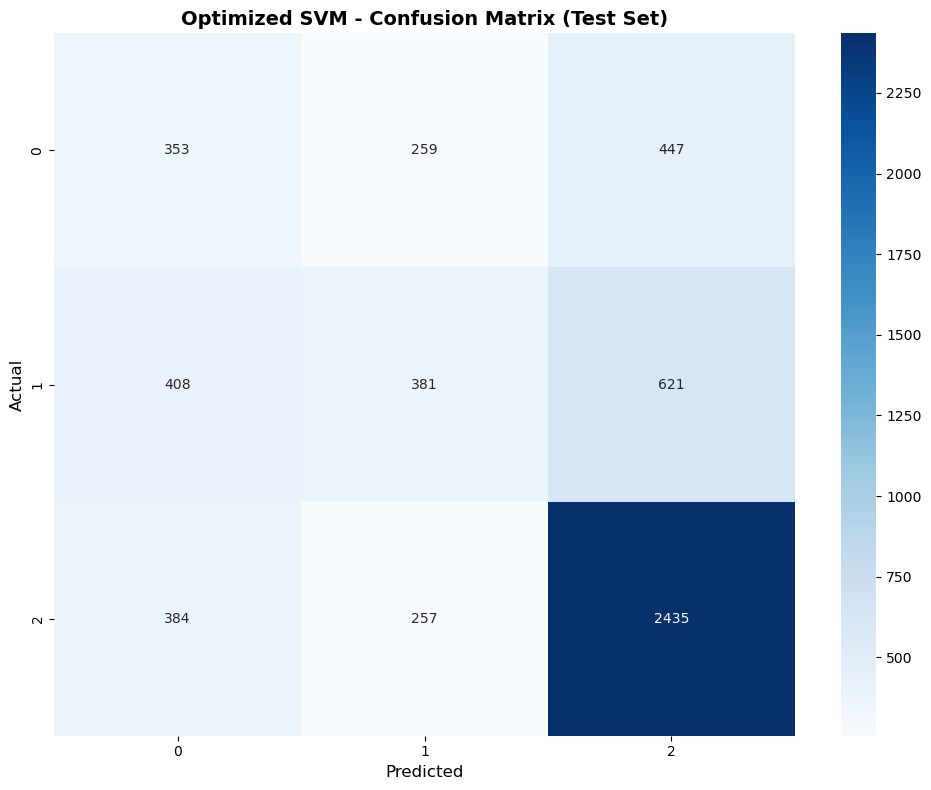

In [18]:
# ================================================================
# 11. CONFUSION MATRIX VISUALIZATION
# ================================================================

print(f"\n📊 CREATING CONFUSION MATRIX...")

# Calculate confusion matrix
cm = confusion_matrix(y_test_svm, y_pred_test)

# Get unique class labels
class_labels = sorted(np.unique(y_train_svm))

# Create plain-text confusion matrix table
print(f"\n📋 CONFUSION MATRIX (Plain Text):")
print("=" * 50)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
cm_df.index.name = 'Actual'
cm_df.columns.name = 'Predicted'
print(cm_df)
print("=" * 50)

# Create confusion matrix plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Optimized SVM - Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()

In [19]:
# ================================================================
# 12. TOP 5 PARAMETER COMBINATIONS
# ================================================================

print(f"\n🔍 TOP 5 SVM PARAMETER COMBINATIONS")
print("=" * 60)

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(grid_search.cv_results_)
primary_score_col = f'mean_test_{recommended_scoring}'

# Get top 5 combinations
top_5_results = results_df.nlargest(5, primary_score_col)

print(f"🏆 Top 5 combinations (ranked by {recommended_scoring}):")
print("-" * 80)

for i, (idx, row) in enumerate(top_5_results.iterrows(), 1):
    score = row[primary_score_col]
    std_score = row[f'std_test_{recommended_scoring}']
    params = row['params']
    
    print(f"{i}. Score: {score:.4f} ± {std_score:.4f}")
    print(f"   Parameters: {params}")
    print()


🔍 TOP 5 SVM PARAMETER COMBINATIONS
🏆 Top 5 combinations (ranked by f1_weighted):
--------------------------------------------------------------------------------
1. Score: 0.5596 ± 0.0062
   Parameters: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}

2. Score: 0.5596 ± 0.0062
   Parameters: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}

3. Score: 0.5585 ± 0.0073
   Parameters: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}

4. Score: 0.5585 ± 0.0073
   Parameters: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'linear'}

5. Score: 0.5577 ± 0.0071
   Parameters: {'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}



In [21]:
# ================================================================
# 13. SVM COEFFICIENT ANALYSIS (FOR LINEAR KERNEL)
# ================================================================

print(f"\n🔍 SVM MODEL ANALYSIS")
print("=" * 60)

if best_kernel == 'linear':
    print("📊 LINEAR SVM COEFFICIENT ANALYSIS:")
    print("-" * 50)
    
    # Get coefficients for linear SVM
    if hasattr(best_svm_model, 'coef_'):
        # For multiclass, coef_ has shape (n_classes, n_features) for OvR
        # or (n_classes * (n_classes-1) / 2, n_features) for OvO
        coefficients = best_svm_model.coef_
        
        if len(coefficients.shape) > 1 and coefficients.shape[0] > 1:
            # Multi-class case - take mean absolute coefficients across classes
            mean_abs_coef = np.mean(np.abs(coefficients), axis=0)
        else:
            mean_abs_coef = np.abs(coefficients[0])
        
        # Create coefficient importance DataFrame
        coef_importance = pd.DataFrame({
            'feature': X_train_svm.columns,
            'importance': mean_abs_coef
        }).sort_values('importance', ascending=False)
        
        print("📊 TOP 10 MOST IMPORTANT FEATURES (by coefficient magnitude):")
        print("-" * 50)
        for i, row in coef_importance.head(10).iterrows():
            print(f"{coef_importance.index.get_loc(i)+1:2d}. {row['feature']:25s}: {row['importance']:.4f}")
        
        # Create coefficient importance plot
        plt.figure(figsize=(12, 8))
        top_10_features = coef_importance.head(10)[::-1]  # Reverse for horizontal bar plot
        plt.barh(range(len(top_10_features)), top_10_features['importance'])
        plt.yticks(range(len(top_10_features)), top_10_features['feature'])
        plt.xlabel('Coefficient Magnitude', fontsize=12)
        plt.title('Top 10 Feature Importance - Linear SVM (Coefficient Magnitude)', fontsize=14, fontweight='bold')
        plt.grid(axis='x', alpha=0.3)
        
        # Add value labels on bars
        for i, v in enumerate(top_10_features['importance']):
            plt.text(v + 0.01 * max(top_10_features['importance']), i, f'{v:.3f}', 
                     va='center', fontsize=10)
        
        plt.tight_layout()
        plt.show()
    else:
        print("❌ Coefficients not available for this SVM configuration")
else:
    print(f"📊 NON-LINEAR SVM ANALYSIS (Kernel: {best_kernel}):")
    print("-" * 50)
    print("🔍 Non-linear kernels don't provide direct feature importance")
    print("   Feature importance through coefficients is only available for linear SVMs")
    print(f"   Your {best_kernel} kernel creates non-linear decision boundaries")
    print("   Consider using permutation importance for more feature analysis")

print(f"\n🎯 SVM DECISION BOUNDARY CHARACTERISTICS:")
print(f"   Kernel type: {best_kernel}")
print(f"   Number of classes: {len(class_labels)}")
print(f"   Decision function shape: {best_svm_model.decision_function(X_test_svm[:1]).shape}")



🔍 SVM MODEL ANALYSIS
📊 NON-LINEAR SVM ANALYSIS (Kernel: rbf):
--------------------------------------------------
🔍 Non-linear kernels don't provide direct feature importance
   Feature importance through coefficients is only available for linear SVMs
   Your rbf kernel creates non-linear decision boundaries
   Consider using permutation importance for more feature analysis

🎯 SVM DECISION BOUNDARY CHARACTERISTICS:
   Kernel type: rbf
   Number of classes: 3
   Decision function shape: (1, 3)


In [22]:
# ================================================================
# 14. FINAL OPTIMIZED MODEL CODE
# ================================================================

print(f"\n💾 OPTIMIZED SVM MODEL FOR PRODUCTION")
print("=" * 60)

print("✅ Your optimized SVM model with required preprocessing:")
print()
print("# STEP 1: Feature Scaling (MANDATORY for SVM)")
print("from sklearn.preprocessing import StandardScaler")
print("scaler = StandardScaler()")
print("X_train_scaled = scaler.fit_transform(X_train)")
print("X_test_scaled = scaler.transform(X_test)")
print()
print("# STEP 2: Create optimized SVM model")
print("from sklearn.svm import SVC")
print("optimized_svm = SVC(")
for param, value in grid_search.best_params_.items():
    if isinstance(value, str):
        print(f"    {param}='{value}',")
    else:
        print(f"    {param}={value},")
print("    random_state=42,")
print("    probability=True,  # Enable probability estimates")
print("    cache_size=1000   # Increase cache for faster training")
print(")")
print()
print("# STEP 3: Train and use the model")
print("optimized_svm.fit(X_train_scaled, y_train)")
print("y_pred = optimized_svm.predict(X_test_scaled)")
print("y_pred_proba = optimized_svm.predict_proba(X_test_scaled)")
print()
print("⚠️  CRITICAL: Always apply the SAME scaler to new data!")
print("   new_data_scaled = scaler.transform(new_data)")


💾 OPTIMIZED SVM MODEL FOR PRODUCTION
✅ Your optimized SVM model with required preprocessing:

# STEP 1: Feature Scaling (MANDATORY for SVM)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# STEP 2: Create optimized SVM model
from sklearn.svm import SVC
optimized_svm = SVC(
    C=0.1,
    class_weight='balanced',
    gamma='scale',
    kernel='rbf',
    random_state=42,
    probability=True,  # Enable probability estimates
    cache_size=1000   # Increase cache for faster training
)

# STEP 3: Train and use the model
optimized_svm.fit(X_train_scaled, y_train)
y_pred = optimized_svm.predict(X_test_scaled)
y_pred_proba = optimized_svm.predict_proba(X_test_scaled)

⚠️  CRITICAL: Always apply the SAME scaler to new data!
   new_data_scaled = scaler.transform(new_data)


In [23]:
# ================================================================
# 15. PERFORMANCE SUMMARY
# ================================================================

print(f"\n📈 SVM PERFORMANCE SUMMARY")
print("=" * 60)

print(f"🎯 Optimization Results:")
print(f"   Best CV {recommended_scoring}: {grid_search.best_score_:.4f}")
print(f"   Test set accuracy:           {test_accuracy:.4f}")
print(f"   Test set F1-weighted:        {test_f1_weighted:.4f}")
print(f"   Test set F1-macro:           {test_f1_macro:.4f}")

print(f"\n⚙️  Best SVM Hyperparameters:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n🎯 SVM Model Characteristics:")
print(f"   Kernel type: {best_kernel}")
print(f"   Total support vectors: {total_support_vectors:,}")
print(f"   Support vector ratio: {support_vector_percentage:.1f}%")
print(f"   Feature scaling: StandardScaler applied")

print(f"\n⏱️  Optimization Details:")
print(f"   Total combinations tested: {total_combinations}")
print(f"   Cross-validation folds: {cv_folds}")
print(f"   Runtime: {total_time/60:.1f} minutes")
print(f"   Primary scoring metric: {recommended_scoring}")

print(f"\n🎉 SVM OPTIMIZATION COMPLETE!")
print("Your SVM model is now optimized and ready to use!")



📈 SVM PERFORMANCE SUMMARY
🎯 Optimization Results:
   Best CV f1_weighted: 0.5596
   Test set accuracy:           0.5715
   Test set F1-weighted:        0.5558
   Test set F1-macro:           0.4636

⚙️  Best SVM Hyperparameters:
   C: 0.1
   class_weight: balanced
   gamma: scale
   kernel: rbf

🎯 SVM Model Characteristics:
   Kernel type: rbf
   Total support vectors: 19,327
   Support vector ratio: 87.1%
   Feature scaling: StandardScaler applied

⏱️  Optimization Details:
   Total combinations tested: 24
   Cross-validation folds: 5
   Runtime: 75.1 minutes
   Primary scoring metric: f1_weighted

🎉 SVM OPTIMIZATION COMPLETE!
Your SVM model is now optimized and ready to use!


In [24]:
# ================================================================
# 16. SAVE PERFORMANCE METRICS
# ================================================================

print(f"\n📊 SAVING SVM PERFORMANCE METRICS")
print("=" * 60)

# Create directory structure
base_dir = "../Data"
model_metrics_dir = os.path.join(base_dir, "model_metrics")
models_dir = os.path.join(model_metrics_dir, "models")
metrics_dir = os.path.join(model_metrics_dir, "metrics")
reports_dir = os.path.join(model_metrics_dir, "reports")

# Create directories if they don't exist
os.makedirs(models_dir, exist_ok=True)
os.makedirs(metrics_dir, exist_ok=True)
os.makedirs(reports_dir, exist_ok=True)

model_name = "svm_optimized"

# Save the trained model AND the scaler (both required for SVM)
model_path = os.path.join(models_dir, f"{model_name}.pkl")
scaler_path = os.path.join(models_dir, f"{model_name}_scaler.pkl")

joblib.dump(best_svm_model, model_path)
joblib.dump(scaler, scaler_path)

print(f"✅ SVM model saved to: {model_path}")
print(f"✅ Scaler saved to: {scaler_path}")
print(f"📏 Model file size: {os.path.getsize(model_path) / (1024*1024):.2f} MB")
print(f"📏 Scaler file size: {os.path.getsize(scaler_path) / (1024*1024):.2f} MB")

# Helper function to convert numpy types to Python native types
def convert_numpy_types(obj):
    """Convert numpy types to Python native types for JSON serialization"""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    else:
        return obj

# Prepare comprehensive metrics dictionary
model_metrics = {
    "model_info": {
        "model_name": "Support Vector Machine (SVM)",
        "optimization_method": "GridSearchCV",
        "primary_scoring_metric": recommended_scoring,
        "total_runtime_minutes": round(total_time/60, 2),
        "feature_scaling": "StandardScaler (REQUIRED for SVM)"
    },
    "dataset_info": {
        "training_samples": int(X_train_svm.shape[0]),
        "test_samples": int(X_test_svm.shape[0]),
        "n_features": int(X_train_svm.shape[1]),
        "n_classes": int(len(np.unique(y_train_svm))),
        "class_distribution": {str(k): int(v) for k, v in class_counts.items()}
    },
    "hyperparameters": {
        "best_params": convert_numpy_types(grid_search.best_params_),
        "total_combinations_tested": int(total_combinations),
        "cv_folds": cv_folds
    },
    "cross_validation_results": {
        "best_cv_score": float(grid_search.best_score_),
        "cv_scores_by_metric": {}
    },
    "test_set_performance": {
        "accuracy": float(test_accuracy),
        "f1_weighted": float(test_f1_weighted),
        "f1_macro": float(test_f1_macro)
    },
    "svm_specific_analysis": {
        "kernel_type": str(best_kernel),
        "regularization_C": float(grid_search.best_params_.get('C', 1.0)),
        "gamma_parameter": str(grid_search.best_params_.get('gamma', 'scale')),
        "support_vectors": {
            "total_support_vectors": int(total_support_vectors),
            "support_vectors_per_class": [int(x) for x in n_support_vectors],
            "support_vector_percentage": float(support_vector_percentage)
        },
        "class_balance_handling": {
            "method": "class_weight='balanced'" if grid_search.best_params_.get('class_weight') == 'balanced' else "No class balancing",
            "imbalance_ratio": float(imbalance_ratio)
        },
        "preprocessing_requirements": {
            "feature_scaling": "MANDATORY - StandardScaler applied",
            "scaler_file": scaler_path
        }
    }
}

# Add coefficient analysis if linear kernel
if best_kernel == 'linear' and hasattr(best_svm_model, 'coef_'):
    model_metrics["svm_specific_analysis"]["linear_coefficients"] = {
        "coefficient_analysis_available": True,
        "top_10_features_by_coefficient": [
            {
                "feature": str(row['feature']),
                "coefficient_magnitude": float(row['importance']),
                "rank": int(coef_importance.index.get_loc(i) + 1)
            }
            for i, row in coef_importance.head(10).iterrows()
        ]
    }
else:
    model_metrics["svm_specific_analysis"]["feature_importance"] = {
        "coefficient_analysis_available": False,
        "reason": f"Coefficient analysis only available for linear kernels. Current kernel: {best_kernel}",
        "alternative": "Consider permutation importance for feature analysis"
    }

# Add detailed CV results for all metrics
cv_results = grid_search.cv_results_
best_index = grid_search.best_index_

for metric_name in scoring_metrics.keys():
    score_key = f'mean_test_{metric_name}'
    std_key = f'std_test_{metric_name}'
    
    if score_key in cv_results:
        model_metrics["cross_validation_results"]["cv_scores_by_metric"][metric_name] = {
            "mean": float(cv_results[score_key][best_index]),
            "std": float(cv_results[std_key][best_index])
        }

# Convert the entire dictionary to ensure all numpy types are handled
model_metrics = convert_numpy_types(model_metrics)

# Save metrics as JSON
metrics_path = os.path.join(metrics_dir, f"{model_name}_metrics.json")
with open(metrics_path, 'w') as f:
    json.dump(model_metrics, f, indent=2)

print(f"✅ Metrics saved to: {metrics_path}")


📊 SAVING SVM PERFORMANCE METRICS
✅ SVM model saved to: ../Data\model_metrics\models\svm_optimized.pkl
✅ Scaler saved to: ../Data\model_metrics\models\svm_optimized_scaler.pkl
📏 Model file size: 3.62 MB
📏 Scaler file size: 0.00 MB
✅ Metrics saved to: ../Data\model_metrics\metrics\svm_optimized_metrics.json


In [25]:
# ================================================================
# 17. SAVE CLASSIFICATION REPORT AND CREATE USAGE INSTRUCTIONS
# ================================================================

print(f"\n📋 SAVING CLASSIFICATION REPORT & USAGE INSTRUCTIONS")
print("=" * 60)

# Generate detailed classification report
class_report_dict = classification_report(y_test_svm, y_pred_test, output_dict=True)

# Save classification report
report_path = os.path.join(reports_dir, f"{model_name}_classification_report.json")
with open(report_path, 'w') as f:
    json.dump(class_report_dict, f, indent=2)

print(f"✅ Classification report saved to: {report_path}")

# Save confusion matrix data
confusion_matrix_data = {
    "confusion_matrix": cm.tolist(),
    "class_labels": sorted(np.unique(y_train_svm).tolist()),
    "model_name": model_name
}

cm_path = os.path.join(metrics_dir, f"{model_name}_confusion_matrix.json")
with open(cm_path, 'w') as f:
    json.dump(confusion_matrix_data, f, indent=2)

print(f"✅ Confusion matrix saved to: {cm_path}")

# Create comprehensive usage instructions
instructions = f"""
SUPPORT VECTOR MACHINE (SVM) MODEL USAGE INSTRUCTIONS
====================================================

Model Information:
- Model Name: {model_name}
- Model Type: Support Vector Machine (Optimized)
- Model File: {model_path}
- Scaler File: {scaler_path}

⚠️  CRITICAL: SVM REQUIRES FEATURE SCALING!

LOADING THE MODEL:
-----------------
```python
import joblib
import pandas as pd
import numpy as np

# Load BOTH the trained model AND the scaler
model = joblib.load('{model_path}')
scaler = joblib.load('{scaler_path}')

# MANDATORY: Scale new data using the SAME scaler
X_new_scaled = scaler.transform(X_new)

# Make predictions on scaled data
predictions = model.predict(X_new_scaled)
prediction_probabilities = model.predict_proba(X_new_scaled)
```

⚠️  NEVER skip feature scaling! SVM will give incorrect results on unscaled data.

BEST HYPERPARAMETERS:
-------------------
{json.dumps(grid_search.best_params_, indent=2)}

PERFORMANCE METRICS:
------------------
- Test Accuracy: {test_accuracy:.4f}
- Test F1-Weighted: {test_f1_weighted:.4f}
- Test F1-Macro: {test_f1_macro:.4f}
- Best CV Score ({recommended_scoring}): {grid_search.best_score_:.4f}

SVM-SPECIFIC INSIGHTS:
---------------------
- Kernel type: {best_kernel}
- Regularization parameter (C): {grid_search.best_params_.get('C', 'N/A')}
- Gamma parameter: {grid_search.best_params_.get('gamma', 'N/A')}
- Total support vectors: {total_support_vectors:,}
- Support vector percentage: {support_vector_percentage:.1f}%
- Class balancing: {'Applied' if grid_search.best_params_.get('class_weight') == 'balanced' else 'Not applied'}

SUPPORT VECTORS BY CLASS:
------------------------
"""

for i, (class_label, sv_count) in enumerate(zip(class_labels, n_support_vectors)):
    instructions += f"Class {class_label}: {sv_count:,} support vectors\n"

if best_kernel == 'linear' and 'coef_importance' in locals():
    instructions += f"""

TOP 5 MOST IMPORTANT FEATURES (Linear SVM Coefficients):
--------------------------------------------------------
"""
    for i, row in coef_importance.head(5).iterrows():
        instructions += f"{coef_importance.index.get_loc(i)+1}. {row['feature']}: {row['importance']:.4f}\n"
else:
    instructions += f"""

FEATURE IMPORTANCE:
------------------
Feature importance analysis not available for {best_kernel} kernel.
Linear SVM provides coefficient-based importance.
For non-linear kernels, consider permutation importance.
"""

instructions += f"""

CLASS DISTRIBUTION:
------------------
"""

for class_label, count in class_counts.items():
    percentage = class_percentages[class_label]
    instructions += f"Class {class_label}: {count:,} samples ({percentage:.1f}%)\n"

instructions += f"""

FILES SAVED:
-----------
- Model: {model_path}
- Scaler: {scaler_path}
- Metrics: {metrics_path}
- Classification Report: {report_path}
- Confusion Matrix: {cm_path}
- Usage Instructions: This file

PREPROCESSING PIPELINE:
---------------------
1. Load your scaler: scaler = joblib.load('{scaler_path}')
2. Scale features: X_scaled = scaler.transform(X_raw)
3. Make predictions: predictions = model.predict(X_scaled)

NOTES:
-----
- This model was optimized using GridSearchCV
- Total combinations tested: {total_combinations}
- Cross-validation: 5-fold
- Optimization runtime: {total_time/60:.1f} minutes
- Primary scoring metric: {recommended_scoring}
- Class imbalance ratio: {imbalance_ratio:.2f}:1

⚠️  CRITICAL SVM REQUIREMENTS:
   - Feature scaling is MANDATORY
   - Both model AND scaler files are required
   - Apply scaler to ALL new data before prediction

🎯 SVM ADVANTAGES:
   - Excellent for high-dimensional data
   - Memory efficient (uses support vectors only)
   - Versatile kernels for different data patterns
   - Strong theoretical foundation

⚠️  SVM CONSIDERATIONS:
   - Slower training than tree-based models
   - Requires careful hyperparameter tuning
   - Sensitive to feature scaling
   - Can be memory intensive for large datasets
"""

instructions_path = os.path.join(model_metrics_dir, f"{model_name}_USAGE_INSTRUCTIONS.txt")
with open(instructions_path, 'w') as f:
    f.write(instructions)

print(f"✅ Usage instructions saved to: {instructions_path}")

print(f"\n🎉 SVM MODEL EXPORT COMPLETE!")
print(f"📂 All files are stored in: {model_metrics_dir}")
print(f"\n💡 To load this model later:")
print(f"   model = joblib.load('{model_path}')")
print(f"   scaler = joblib.load('{scaler_path}')")

print("\n🎉 SVM MODEL TRAINING AND EVALUATION COMPLETED!")
print("=" * 60)
print(f"📈 Final Test Accuracy: {test_accuracy:.4f}")
print(f"🎯 Best CV Score ({recommended_scoring}): {grid_search.best_score_:.4f}")
print(f"🔧 Kernel Used: {best_kernel}")
print(f"⚡ Support Vectors: {total_support_vectors:,} ({support_vector_percentage:.1f}%)")
print("=" * 60)
print("⚠️  Remember: Always apply feature scaling to new data!")


📋 SAVING CLASSIFICATION REPORT & USAGE INSTRUCTIONS
✅ Classification report saved to: ../Data\model_metrics\reports\svm_optimized_classification_report.json
✅ Confusion matrix saved to: ../Data\model_metrics\metrics\svm_optimized_confusion_matrix.json
✅ Usage instructions saved to: ../Data\model_metrics\svm_optimized_USAGE_INSTRUCTIONS.txt

🎉 SVM MODEL EXPORT COMPLETE!
📂 All files are stored in: ../Data\model_metrics

💡 To load this model later:
   model = joblib.load('../Data\model_metrics\models\svm_optimized.pkl')
   scaler = joblib.load('../Data\model_metrics\models\svm_optimized_scaler.pkl')

🎉 SVM MODEL TRAINING AND EVALUATION COMPLETED!
📈 Final Test Accuracy: 0.5715
🎯 Best CV Score (f1_weighted): 0.5596
🔧 Kernel Used: rbf
⚡ Support Vectors: 19,327 (87.1%)
⚠️  Remember: Always apply feature scaling to new data!
